In [109]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle
import gc
import numpy as np
import cv2

from lib.utils import load_gtsrb
from patch_model import *
from stn.conv_model import conv_model_no_color_adjust

from patch_model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

In [57]:
batch_size = 32
l2_reg = 1e-4

In [4]:
signnames = pd.read_csv('/data/signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

In [142]:
model = conv_model_no_color_adjust()
model.load_weights("./keras_weights/stn_v5.hdf5")
stn_weight = model.layers[1].get_weights()
# Delete STN to reclaim unused GPU memory
del model
gc.collect()

model, model_map = build_patch_model_resnet(patch_size=8,
                                            use_stn=True,
                                            stn_weight=stn_weight,
                                            l2_reg=l2_reg,
                                            patch_scheme='all',
                                            num_patches_total=32,
                                            use_batchnorm=True)

In [143]:
# model.load_weights('./saved_models/train_patch_net_exp11.h5')
model_map.load_weights('./saved_models/train_patch_net_exp11.h5')

In [ ]:
# Load weight from model with random patch to model that takes all patches
model_temp, _ = build_patch_model_resnet(patch_size=8,
                                         use_stn=True,
                                         stn_weight=stn_weight,
                                         l2_reg=l2_reg,
                                         patch_scheme='random',
                                         num_patches_total=32,
                                         use_batchnorm=False)

model_temp.load_weights('./saved_models/train_patch_net_exp12.h5')

source_layers = model_temp.layers_by_depth
target_layers = model_map.layers_by_depth
assert len(source_layers) == len(target_layers)
layer_names = ['conv2d', 'dense']

for i in source_layers:
    layer = source_layers[i]
    if len(layer) > 2:
        continue
    for j, l in enumerate(layer):
        if (('conv2d' in l.get_config()['name']) or 
            ('dense' in l.get_config()['name'])):
            weights = l.get_weights()
            target_layers[i - 1][j].set_weights(weights)
            
del model_temp
gc.collect()

In [144]:
y = model_map.predict(X_test)

In [145]:
np.mean(np.argmax(np.mean(y, 1), -1) == y_test)

0.9665083135391924

1


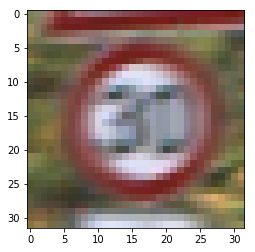

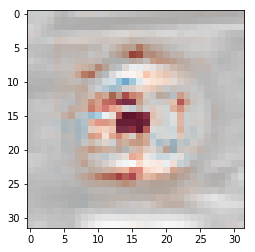

In [153]:
i = 110
print(np.argmax(np.mean(y, 1), -1)[i])
plt.imshow(X_test[i])
plt.show()

heatmap = y[i, :, y_test[i]]
heatmap = heatmap.reshape(32, 32)
abs_max = np.percentile(np.abs(heatmap), 99)
abs_min = - abs_max
plt.imshow(heatmap, cmap='RdBu_r', vmin=abs_min, vmax=abs_max)
gray = cv2.cvtColor(X_test[i], cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray', alpha=0.3)
plt.show()

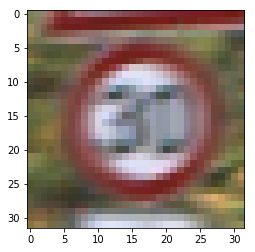

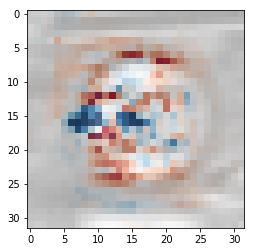

In [157]:
i = 110
plt.imshow(X_test[i])
plt.show()

heatmap = y[i, :, 0]
heatmap = heatmap.reshape(32, 32)
abs_max = np.percentile(np.abs(heatmap), 99)
abs_min = - abs_max
plt.imshow(heatmap, cmap='RdBu_r', vmin=abs_min, vmax=abs_max)
gray = cv2.cvtColor(X_test[i], cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray', alpha=0.3)
plt.show()

In [156]:
np.array(signnames)[0]

array([0, 'Speed limit (20km/h)'], dtype=object)